# Experiment with ibovespa index


**Data selection:**

Each tested period = Each index composition from 10 years ago quarterly -> desenhos de essas janelas!
Each fold = training period (252 days behind); Test period (93)

The performance then is evaluated quarterly to avoid selection bias! Which was higly present on the studies following deepportfolios.


**Steps:**

1. Execute the market modeling step to somehow differenciate the stocks different from the market! -> First stage of non-linear projection
3. Ammend the ibovespa returns as an arbritary way to explore for arbritage opportunities
    3.1 mode one: Same as the article, arbritage opportunities in shocks! (negative correlation)
    3.2 mode two: diluted returns! a modification from the original article
4. Apply calibration step  for the ammended index return! and see if such factors are beaten somehow!
    4.1 we might coin this new findings to a new non-linear factor capable of surpass in both modes
5. Compare wether this methodology improves over the benchmark index



**Initial observations**:

1. When the factor is represented with positive and negative loads (long-short representation) the network lacks capabilities to deal with that, even posible negative correlated stocks are involved!
2. Long portfolios are well represented, although results are pending to see if there was any imprvements
3. The networks, in portfolio (calibration stage)
4. From few sample observations, results are not as promising as the other studies considering the other studies fell in seelction bias for the indexes they tested, which could lead to overestimate returns!



**COnsiderations:**

1. Experiments with index ongoing! to test selection bias in index

**Doubts:**

1. Autoencodeers from a financial point of view, represent more component besides the trend, seasonal, and so on?


Boa referencia de autoencoder y un párrafo para evitar describir autoencoders! seguine autoencoder siguiendo las mejores p'racticas


In [1]:
import copy
import datetime
import os

import pandas as pd
import numpy as np
 
import src.utils.returns_preprocessing as preproc
import src.pca.eigen_portfolios_functions as eg_functions

import src.autoencoders.autoencoder_market_projection as ae_market
import src.autoencoders.autoencoder_portfolio_calibration as ae_portfolio_cal

import src.utils.portfolio_utils as portfolio_utils
import src.pca.rmf_filtering as rmf_filter

import src.metrics.sharpe_ratio_stats as sharpe_ratio_stats

import logging
logging.getLogger('tensorflow').disabled = True


%load_ext autoreload
%autoreload 2

2023-04-13 21:40:19.422324: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Reading the data

in this stage, I must collect other actions!!

In [2]:
# load from persisted data
index_ticker = '^BVSP'
# Transforming all pdf index to csv
base_path = './data/ibov_comp_10_anos/prices_v2/'

quarter_ibovespa_datasets, quarter_index = [], []
for filename in os.listdir(base_path):
    # check if the filename is a file (not a directory)
    if os.path.isfile(os.path.join(base_path, filename)):
        if '_ibov.csv' in filename:
            quarter_ibovespa_datasets.append(filename)
  

In [3]:
# test
def removing_nan_stocks(df_prices, null_treshold_head = 0.05):
    df_prices_ = df_prices.copy()
    treshold = int(df_prices.shape[0]*null_treshold_head)
    # removing older null nan
    for col in df_prices.columns:
        if df_prices[col].head(treshold).isnull().sum() >= treshold:
            df_prices_ = df_prices_.drop(col, axis = 1)
    # starting dataseet from where there are not null values
    df_prices_ = df_prices_[df_prices_.isnull().sum().max():]
    return df_prices_


month = {'jan':'01', 'abr':'04','jul':'07', 'out':'10'}
perce_not_nan = 0.75

dataframes,non_considered_dataframes = {},{}
for file_name in quarter_ibovespa_datasets:
    df_prices = pd.read_csv('./data/ibov_comp_10_anos/prices_v2/'+file_name)
    num_tickers = len(df_prices.columns)
    # removing nan
    _date = file_name[14:18] +'-' +month[file_name[10:13]]
    df_prices = removing_nan_stocks(df_prices, null_treshold_head = 0.12)
    # filtering fold with enough data
    perc_non_empty_stocks = len(df_prices.columns) / num_tickers
    if perc_non_empty_stocks >= perce_not_nan:
        dataframes[_date] = df_prices
    else:
        non_considered_dataframes[_date] = perc_non_empty_stocks

    
#v1
#_date = file_name[11:15] +'-' +month[file_name[7:10]]
#df_index = pd.read_csv('./data/ibov_comp_10_anos/prices/indexibovespa_'+_date+'.csv')
#df_prices = df_prices.join(df_index)
    


-----------------------------------------|------------------------------ 
Training set:             Date: INdex Quarterly calibration     test

### Orchestrator! .....

In [4]:
#set for invoking each dataframe! pending implement defkated sharpe value!

index_ticker = '^BVSP'
def flow_orchrestrator(df_in_sample, 
                       df_out_of_sample, 
                       folds = 2, 
                      risk_free_rate = 0.04,
                      top_communal = 15,
                      bottom_communal = 20):


    # training
    df_in_simple_returns = preproc.get_simple_returns_from_prices(df_in_sample).dropna()
    df_in_log_returns = preproc.simple_to_log_returns(df_in_simple_returns)
    df_in_log_returns_without_index = df_in_log_returns.drop(index_ticker, axis = 1)
    
    y_log = df_in_log_returns[index_ticker]
    
    #def train_orchestrator():
    # 1. market modeling factors -- Tune network parameters -> tanh is the best activation layer, other experiments with other activation fucntions were done, but were not 
    model, communal_assets = non_linear_factors_mapping(df_in_log_returns_without_index, epochs = 500)
    df_log_train_index_stocks, df_log_train_arbritage_stocks = selecting_tickers(df_in_log_returns_without_index, communal_assets, top_communal, bottom_communal)
    selected_communal_assets = set(df_log_train_index_stocks.columns).union(set(df_log_train_arbritage_stocks.columns))

    # 2. calibration stage - for each factor
    #factors_to_test = filtered_linear_factors[14]['weights']
    y_log_ammended = ammend_y_targets(y_log, rate_target = 0.01, ammend_shocks = True)
    train = df_log_train_index_stocks.join(df_log_train_arbritage_stocks)
    # train
    calibration_model, train_results = non_linear_factors_calibration(train, y_log, y_log_ammended)
    
    # calculate out of samples results
    test_results = out_of_sample_results(df_out_of_sample, calibration_model, selected_communal_assets, set(df_log_train_index_stocks.columns)) # which one would be the reference Y
     
    return {'calibration_model': calibration_model, 
            'train_results': train_results,
            'communal_assets': selected_communal_assets,
            'test_results': test_results}


In [8]:
#walk-forward

bottom_communal = [5,10,15,20,25]
for bottom in bottom_communal:
    iterations = {}
    for _date, df in dataframes.items():
        print(_date)
        df_in_sample, df_out_sample = df.head(len(df)-93), df.tail((93))
        one_iteration = flow_orchrestrator(df_in_sample, df_out_sample, folds = 2, 
                              risk_free_rate = 0.04,
                              top_communal = 15,
                              bottom_communal = 20)
        iterations[_date] = one_iteration
        
    with open('./results/cache/index_results_'+str(bottom)+'.pickle', 'wb') as output:
        pickle.dump(iterations, output)


2018-07
3/3 [==============================] - 0s 1ms/step
2019-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2019-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2018-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2015-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2020-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2021-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2022-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2015-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2014-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2017-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2016-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2023-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2021-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2020-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2016-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 2ms/step
2017-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2019-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 2ms/step
2018-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2018-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2019-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2020-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 2ms/step
2021-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2022-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2015-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2014-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2021-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2020-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2016-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2017-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2014-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2015-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2023-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2022-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2017-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2016-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


2018-07
3/3 [==============================] - 0s 2ms/step
2019-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2019-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2018-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2015-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2020-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2021-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2022-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2015-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2014-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2017-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 2ms/step
2016-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2023-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2021-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2020-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2016-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2017-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2019-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2018-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2018-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2019-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2020-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2021-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2022-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2015-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2014-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2021-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2020-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 2ms/step
2016-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 2ms/step
2017-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2014-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2015-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 2ms/step
2023-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2022-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2017-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2016-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


2018-07
3/3 [==============================] - 0s 2ms/step
2019-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2019-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2018-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2015-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2020-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2021-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2022-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 2ms/step
2015-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2014-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2017-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2016-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 2ms/step
2023-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2021-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2020-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2016-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2017-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2019-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2018-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2018-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2019-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 2ms/step
2020-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2021-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2022-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2015-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2014-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 2ms/step
2021-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 2ms/step
2020-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 2ms/step
2016-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2017-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2014-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 974us/step
2015-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 3ms/step
2023-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2022-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2017-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2016-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


2018-07
3/3 [==============================] - 0s 1ms/step
2019-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 2ms/step
2019-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2018-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2015-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2020-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2021-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2022-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2015-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2014-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2017-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2016-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2023-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2021-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2020-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2016-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2017-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2019-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2018-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 2ms/step
2018-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 2ms/step
2019-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 2ms/step
2020-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2021-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 2ms/step
2022-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2015-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 2ms/step
2014-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2021-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 3ms/step
2020-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2016-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 2ms/step
2017-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2014-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2015-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2023-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2022-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 2ms/step
2017-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 3ms/step
2016-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


2018-07
3/3 [==============================] - 0s 1ms/step
2019-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2019-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2018-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2015-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2020-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 2ms/step
2021-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2022-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 2ms/step
2015-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 2ms/step
2014-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2017-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 2ms/step
2016-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2023-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 2ms/step
2021-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2020-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2016-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 2ms/step
2017-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2019-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 2ms/step
2018-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2018-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 2ms/step
2019-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2020-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 2ms/step
2021-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2022-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 2ms/step
2015-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2014-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 2ms/step
2021-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2020-10


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 2ms/step
2016-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 3ms/step
2017-07


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2014-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2015-04


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2023-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2022-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2017-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step
2016-01


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


3/3 [==============================] - 0s 1ms/step


/var/folders/9g/fkvk1rlx44s9k648bkf78ssx5xtbf8/T/ipykernel_36378/481835537.py:79: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()


In [7]:
import pickle
with open('./results/index_results.pickle', 'wb') as output:
     pickle.dump(iterations, output)

<AxesSubplot:ylabel='Frequency'>

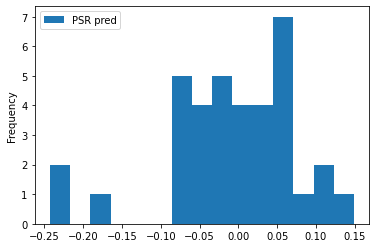

In [64]:
# first factor
psr_diff = []
for k,v in iterations.items():
    psr_diff.append(v['test_results']['TEST_PSR'] - v['test_results']['TREST_PSR_REFERENCE'])

pd.Series(psr_diff).plot.hist(label='PSR pred', legend = True, bins = 15)



In [ ]:
one_iteration = iterations[_date].copy()
plot_cummulative_returns(one_iteration)

In [ ]:
plot_cummulative_test_returns(one_iteration)

In [22]:
one_iteration['test_results']

{'y_target': 219    47813.0
 220    48201.0
 221    47576.0
 222    46600.0
 223    47151.0
         ...   
 307    53506.0
 308    53157.0
 309    53168.0
 310    53171.0
 311    53029.0
 Name: ^BVSP, Length: 93, dtype: float64,
 'y_predicted': 0     0.003568
 1    -0.018040
 2    -0.032892
 3     0.014716
 4     0.010832
         ...   
 87    0.001167
 88   -0.004845
 89   -0.000134
 90   -0.006490
 91   -0.004988
 Length: 92, dtype: float64,
 'TEST_PSR': 0.7994098730698718,
 'TREST_PSR_REFERENCE': 1.0}

### PSB

será que autoencoder.. coptura mais fatores que sazonalidade, componentes
erro de modelo!
Armar hitoria, desapegar de los resultados del artigo! conseguir explicaciones!

### deflated sharpe value
https://quantdare.com/deflated-sharpe-ratio-how-to-avoid-been-fooled-by-randomness/

As the mean is zero, there is no significant difference between the original return given by the risk factor from the eigenportfolio, which means the initial hyphotesis that non-lineraities seeked by a defined target are not found or present.

Next ideas: is go from step 1 of deepportfolios to harness least-communal stocks for the specific target!

is is random!

### Methods

In [5]:
# other methods
def plot_cummulative_returns(factor_iteration):
    ((pd.Series(preproc.log_to_simple_returns(factor_iteration['train_results']['portfolio_log_returns_pred'])) + 1).cumprod() - 1).plot(label='predicted', legend = True)
    ((pd.Series(preproc.log_to_simple_returns(factor_iteration['train_results']['y_log_ammended'])) + 1).cumprod() - 1).plot(label='Target', legend = True)
    ((pd.Series(preproc.log_to_simple_returns(factor_iteration['train_results']['y_log_train'])) + 1).cumprod() -1).plot(label='Original', legend = True)

# other methods
def plot_cummulative_test_returns(factor_iteration):
    ((pd.Series((factor_iteration['test_results']['y_predicted'].values)) + 1).cumprod() - 1).plot(label='predicted', legend = True)
    ((pd.Series((factor_iteration['test_results']['y_target'].values)) + 1).cumprod() -1).plot(label='Original', legend = True)

    

def non_linear_factors_mapping(train, epochs = 500):
    # fit market representation
    encoder_params = {'encoding_dim': 5,
                      'optimizer':'sgd', 
                      'loss':'mean_squared_error',
                      'l2_penalty': 0.01, 
                      'epochs': epochs, 
                      'batch_size': 100, 
                      'shuffle' : False,
                      'scale_data': False,
                      'hidden_layers_activation': 'tanh',# Columbia -> tanh with a batch normalization layer in sequence 
                      'output_activation': 'tanh',# Columbia -> tanh with a batch normalization layer in sequence -> after many tests, tanh is the best  
                      'verbose':0,
                      'batch_normalization': False}
    model = ae_market.autoencoder_market_projection_fit(train, encoder_params)
    # calculating most communal assets
    communal_assets = ae_market.communal_information(train, model) # test or train??
    #results
    return model, communal_assets

def selecting_tickers(df_returns, communal_assets, n_top = 15, n_bottom = 20):
    index_associated_stocks = communal_assets.head(n_top)['ticker']
    arbritage_stocks = communal_assets.tail(n_bottom)['ticker']
    return df_returns[index_associated_stocks], df_returns[arbritage_stocks]

def non_linear_factors_calibration(train, y_log_train, y_log_train_amended, epochs = 500):
    encoder_params = {'encoding_dim': int(train.shape[1]*0.75), #change this if changes a lot
                      'optimizer':'sgd', 
                      'loss':'mean_squared_error',
                      'l2_penalty': 0.01, 
                      'epochs': epochs, 
                      'batch_size': 100, 
                      'shuffle' : False,
                      'scale_data': True,
                      'hidden_layers_activation': 'tanh',# Columbia -> tanh with a batch normalization layer in sequence 
                      'output_activation': 'softmax',
                      'batch_normalization': True,
                      'verbose':0,
                     'custom_loss_function' : ae_portfolio_cal.custom_matmult_rmse_loss}
    calibration_model = ae_portfolio_cal.autoencoder_portfolio_calibration_fit(train, y_log_train_amended, encoder_params)
    # predict
    portfolio_log_returns_train_hat, weights = ae_portfolio_cal.portfolio_returns_predict(train, calibration_model, return_log = True)
    
    _psr_train = sharpe_ratio_stats.probabilistic_sharpe_ratio(pd.Series(preproc.log_to_simple_returns(portfolio_log_returns_train_hat)))
    _psr_reference = sharpe_ratio_stats.probabilistic_sharpe_ratio(pd.Series(preproc.log_to_simple_returns(y_log_train)))
    
    return calibration_model, {'portfolio_log_returns_pred':portfolio_log_returns_train_hat,
                   'y_log_train': y_log_train.values,
                   'y_log_ammended': y_log_train_amended.values,
                  'weights': weights,
                    'TRAIN_PSR_REFERENCE': _psr_reference,
                    'TRAIN_PSR': _psr_train}


def ammend_y_targets(y_log, rate_target = 0.01, ammend_shocks = False):
    if ammend_shocks:
        return preproc.set_target_returns_extreme_effects_by_percentile(y_log, .01, rate_target , 1)
    else:
        return preproc.set_target_spreaded_rate(y_log, rate_target)

    

def out_of_sample_results(df_out_of_sample, calibration_model, communal_assets, index_communal_assets):
    index_ticker = '^BVSP'
    # process df
    df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[communal_assets]).dropna()
    df_out_of_log_returns = preproc.simple_to_log_returns(df_out_of_simple_returns)
    
    portfolios_log_test_returns, _ = ae_portfolio_cal.portfolio_returns_predict(df_out_of_log_returns, calibration_model, return_log = True)
    portfolios_simple_test_returns = preproc.log_to_simple_returns(portfolios_log_test_returns)
    
    # y_target
    y_target = preproc.get_simple_returns_from_prices(df_out_of_sample[index_ticker]).dropna()
        
    # rmse 
    #portfolios_test_returns - y_target
    # PSR
    _psr = sharpe_ratio_stats.probabilistic_sharpe_ratio(pd.Series(portfolios_simple_test_returns))
    _psr_reference = sharpe_ratio_stats.probabilistic_sharpe_ratio(pd.Series(y_target))
    #Deflated_sharpe_value
    
    return {'y_target': y_target,
            'y_predicted': portfolios_simple_test_returns,
            'TEST_PSR': _psr,
           'TREST_PSR_REFERENCE': _psr_reference}
    